In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 47924, number of used features: 20
[LightGBM] [Info] Start training from score -2.389376
[LightGBM] [Info] Start training from score -2.404280
[LightGBM] [Info] Start training from score -2.388467
[LightGBM] [Info] Start training from score -2.395998
[LightGBM] [Info] Start training from score -2.401281
[LightGBM] [Info] Start training from score -2.392111
[LightGBM] [Info] Start training from score -2.409143
[LightGBM] [Info] Start training from score -2.393253
[LightGBM] [Info] Start training from score -2.391883
[LightGBM] [Info] Start training from score -2.402664
[LightGBM] [Info] Start tra

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


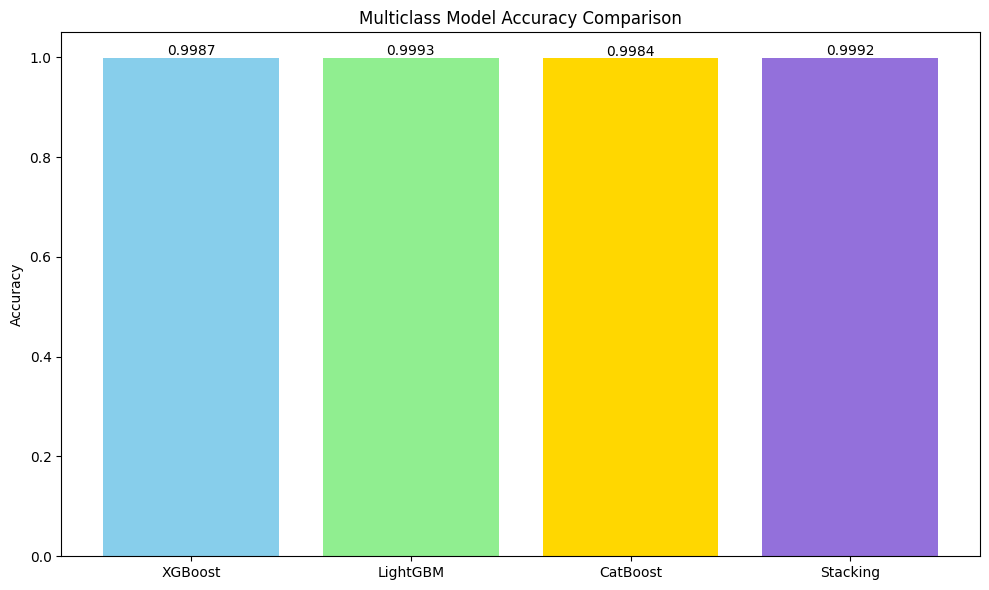

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Load data
df = pd.read_csv("/content/multi_featm_cicids_rfe.csv")

# Encode multiclass labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Features and target
X = df.drop('Label', axis=1)
y = df['Label']

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Results dictionary
results = {}

# XGBoost
xgb = XGBClassifier(
    n_estimators=148,
    max_depth=10,
    learning_rate=0.1175,
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    verbosity=0
)
xgb.fit(X_train, y_train)
results["XGBoost"] = {
    "Accuracy": accuracy_score(y_val, xgb.predict(X_val))
}

# LightGBM
lgb = LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.2,
    objective='multiclass',
    num_class=len(np.unique(y)),
    random_state=42
)
lgb.fit(X_train, y_train)
results["LightGBM"] = {
    "Accuracy": accuracy_score(y_val, lgb.predict(X_val))
}

# CatBoost
cat = CatBoostClassifier(
    iterations=200,
    depth=7,
    learning_rate=0.2,
    loss_function='MultiClass',
    random_seed=42,
    verbose=0
)
cat.fit(X_train, y_train)
results["CatBoost"] = {
    "Accuracy": accuracy_score(y_val, cat.predict(X_val))
}

# Stacking Ensemble
# Get probability predictions on train set
xgb_train_preds = xgb.predict_proba(X_train)
lgb_train_preds = lgb.predict_proba(X_train)
cat_train_preds = cat.predict_proba(X_train)

# Stack them for meta-model training
meta_X_train = np.hstack((xgb_train_preds, lgb_train_preds, cat_train_preds))
meta_y_train = y_train

# Train logistic regression as meta-model
meta_model = LogisticRegression(max_iter=1500, multi_class='multinomial')
meta_model.fit(meta_X_train, meta_y_train)

# Predict probabilities on validation set
xgb_val_preds = xgb.predict_proba(X_val)
lgb_val_preds = lgb.predict_proba(X_val)
cat_val_preds = cat.predict_proba(X_val)

meta_X_val = np.hstack((xgb_val_preds, lgb_val_preds, cat_val_preds))
meta_preds = meta_model.predict(meta_X_val)

# Evaluate stacking model
stacked_accuracy = accuracy_score(y_val, meta_preds)
results["Stacking"] = {
    "Accuracy": stacked_accuracy
}

# Plot Accuracy Comparison
models = list(results.keys())
accuracies = [d['Accuracy'] for d in results.values()]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=["skyblue", "lightgreen", "gold", "mediumpurple"])
plt.ylim(0, 1.05)
plt.ylabel('Accuracy')
plt.title('Multiclass Model Accuracy Comparison')


for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.005, f"{acc:.4f}", ha='center')

plt.tight_layout()
plt.savefig("multiclass_accuracy_comparison_cicids.png", dpi=800)
plt.show()
